## Bibliotecas

In [1]:
# ETL e matemática
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Regressão e métricas
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_squared_log_error

# Treino/teste
from sklearn.model_selection import train_test_split

# Definindo tema Matplot como Seaborn
sns.set()

## Visualizando a relação entre o limite de crédito e o score

In [2]:
# Importando o dataset
df = pd.read_csv('https://s3-sa-east-1.amazonaws.com/lcpi/7c85cb96-165c-49a6-90f6-e35575a4dafe.csv')

In [3]:
# Variável de entrada
X = df['Score'].values

# Variável de saída
Y = df['Limit'].values

# Separando os dados entre teste e treino
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=102)

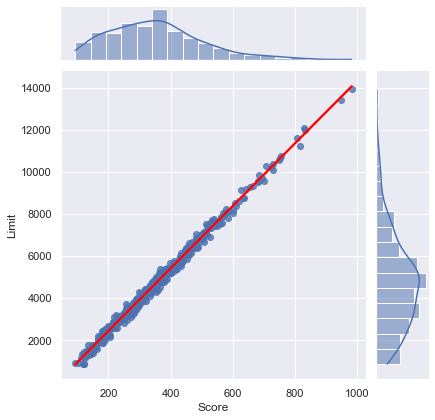

In [4]:
sns.jointplot(data=df, x='Score', y='Limit', kind='reg', joint_kws={'line_kws':{'color':'red'}})
plt.show()

> Visualmente não encontro nenhum ponto que fuja da tendência da reta vermelha, portanto nenhum ponto será excluído da análise.

In [5]:
# Matriz de correlação dos parâmetros
df.corr()

,Limit,Score
Limit,1.00000,0.99688
Score,0.99688,1.00000


A correlação entre os parâmetros Limit e Score, parâmetros que representam o limite de crédito e o Score do Serasa, possuem uma correlação positiva fortíssima (0,99688) o que indica que um modelo de regressão linear será um modelo de predição com boa precisão. 

## Utilizando o Sklearn

In [6]:
# Obtendo a função de Reressão linear do Sklearn
lr = LinearRegression()

In [7]:
# Treinando o modelo com os dados de treino (calculando os coeficientes da regressão)
lr.fit(X_train.reshape(-1, 1), y_train) 

b1, b0 = lr.coef_, lr.intercept_ # Obtendo o valor do beta1 e beta0

b1, b0

(array([14.80929372]), -520.4172427727781)

In [8]:
# Prevendo os valores de limite de crédito para cada score dado
y_est = lr.predict(X_test.reshape(-1, 1)) # Dados de Teste
y_est_train = lr.predict(X_train.reshape(-1, 1)) # Dados do Treino

# Pegando o "head" e "tail"  do array pois ele é grande demais para ser impresso por completo
y_est[:5], y_est[-5:]

(array([2915.33889913, 3344.80841687, 1626.93034592, 3285.57124201,
        5803.15117358]),
 array([4944.2121381 , 4736.88202609, 6958.27608336, 5862.38834844,
        2974.57607399]))

## Utilizando o Statsmodels

In [9]:
# Gerando o modelo
x = sm.add_constant(X)
model = sm.OLS(Y, x).fit()
model.summary() # Sumariza as informações do modelo, dentre elas os coeficientes da curva calculada

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 6.348e+04
Date:                Mon, 21 Feb 2022   Prob (F-statistic):               0.00
Time:                        16:03:04   Log-Likelihood:                -2649.1
No. Observations:                 400   AIC:                             5302.
Df Residuals:                     398   BIC:                             5310.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -542.9282     22.850    -23.760      0.000    -587.851    -498.006
x1            14.8716      0.059    251.949      0.000      14.756      14.988
==============================================================================
Omnibus:                        6.887   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                4.980
Skew:                          -0.145   Prob(JB):                       0.0829
Kurtosis:                       2.537   Cond. No.                         970.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R: B0 = -542.9282 e B1 = 14.8716

## Características do Erro

In [10]:
# Resíduos da regressão linear - via modelo statsmodel
res = model.resid 

res[:5] , res[-5:]

(array([-59.73658403,   4.94199264, -26.07782798, -80.63621646,
        130.76448934]),
 array([  77.34484517,  -21.06747654,  -59.85765446,  212.57966359,
        -104.78872343]))

#### Calculando os residuos (erros) -> Diferença entre o y verdadeiro e o y estimado

In [11]:
# Resíduos da regressão linear - subtraindo os dados de teste do estimado pelo modelo treinado
residuos = y_test - y_est # Usando a previsão do sklearn

residuos[:5] , residuos[-5:]

(array([   7.66110087,   57.19158313, -178.93034592,  214.42875799,
          25.84882642]),
 array([ -53.2121381 , -104.88202609, -139.27608336,  -95.38834844,
         -64.57607399]))

### Características
#### 1. Não devem ser correlacionados

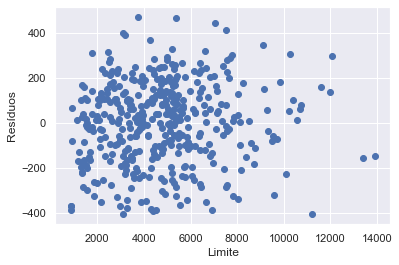

In [12]:
# Dispersão dos resíduos do modelo
plt.scatter(Y, model.resid)
plt.xlabel('Limite')
plt.ylabel('Resíduos')
plt.show()

#### 2. Possuem média igual à zero

In [13]:
# Média dos resíduos do modelo
np.mean(res)

-2.382876118645072e-12

#### 3. Seguem uma Distribuição normal

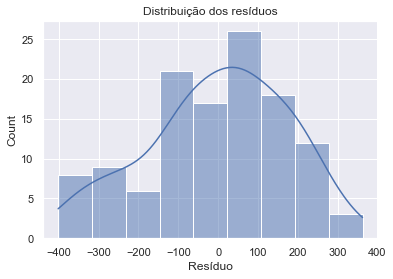

In [14]:
# Distribuição dos resíduos
sns.histplot(residuos, kde=True)
plt.xlabel('Resíduo')
plt.title('Distribuição dos resíduos')
plt.show()

## Métricas para Análise dos Erros

#### 1. R-Quadrado ($R^2$) - Coeficiente de determinação

$$
R^2 = 1 - \frac{SQE}{SQT} = \frac{SQT - SQExp}{SQT} = \frac{SQExp}{SQT}
$$


##### SQE - Soma dos Quadrados dos erros - Variação não explicada

$$
SQE = \sum_{i=1}^N \left[y_i - \hat{y}_i\right]^2
$$

##### SQT - Soma dos Quadrados total - Variação total

$$
SQT = \sum_{i=1}^N \left(\hat{y}_i - \overline{y}\right)^2
$$

##### SQExp - Soma dos Quadrados Explicados - Variação explicada 

$$
SQExp = \sum_{i=1}^N \left(y_i - \overline{y}\right)^2
$$

O coeficiente de determinação indica **o quão próximos os dados estão da reta prevista/determinada pelo modelo**. Por outro lado, o $R^2$ representa a porcentagem de variação na resposta que é explicada pelo modelo. Também conhecido como **percentual de variância explicada** (SQT). Percentual 

In [15]:
# Coeficiente de determinação
print('🏋🏽‍♂️ DADOS DE TREINO 🏋🏽‍♂️')
print('R²:', r2_score(y_train, y_est_train)) # R² para o treino

print('\n🔥 DADOS DE TESTE 🔥')
print('R²:', r2_score(y_test, y_est)) # R² para o teste

🏋🏽‍♂️ DADOS DE TREINO 🏋🏽‍♂️
R²: 0.9939645464650044

🔥 DADOS DE TESTE 🔥
R²: 0.9931085427654337


> É possível utilizar o $R^2$ nos dados de treino, mas isso não é tão significante, devido ao *overfitting*. Mais significativo é calcular o coeficiente de determinação utilizando os dados de teste como feito acima.

#### 2. MAE (Mean Absolute Error)

##### Média Absoluta dos Resíduos

$$
MAE = \frac{1}{N} \sum_{i=1}^N \left|y_i - \hat{y}_i\right|
$$

In [16]:
# Mean Absolute Error
print('🏋🏽‍♂️ DADOS DE TREINO 🏋🏽‍♂️')
print('MAE:', MAE(y_train, y_est_train)) # MAE para o treino

print('\n🔥 DADOS DE TESTE 🔥')
print('MAE:', MAE(y_test, y_est)) # MAE para o teste

🏋🏽‍♂️ DADOS DE TREINO 🏋🏽‍♂️
MAE: 150.57786549701552

🔥 DADOS DE TESTE 🔥
MAE: 142.53061523635307


#### 3. MSE (Mean Square Error) ou SQE (Média dos Quadrados dos Resíduos)

##### Média dos Quadrados dos resíduos

$$
MSE = \frac{SQE}{N} = \frac{1}{N} \sum_{i=1}^N \left(y_i - \hat{y}_i\right)^2
$$

In [17]:
# Mean Square Error
print('🏋🏽‍♂️ DADOS DE TREINO 🏋🏽‍♂️')
print('MSE:', MSE(y_train, y_est_train)) # MSE para o treino

print('\n🔥 DADOS DE TESTE 🔥')
print('MSE:', MSE(y_test, y_est)) # MSE para o teste

🏋🏽‍♂️ DADOS DE TREINO 🏋🏽‍♂️
MSE: 34301.74646355952

🔥 DADOS DE TESTE 🔥
MSE: 30649.85200996823


#### 4. RMSE (Root Mean Square Error)

##### Raiz quadrada da Média dos Quadrados dos resíduos

$$
RMSE = \sqrt{MSE} = \sqrt{\frac{SQE}{N}} = \sqrt{\frac{1}{N} \sum_{i=1}^N \left(y_i - \hat{y}_i\right)^2}
$$

In [18]:
# Root Mean Square Error
print('🏋🏽‍♂️ DADOS DE TREINO 🏋🏽‍♂️')
print('RMSE:', np.sqrt(MSE(y_train, y_est_train))) # RMSE para o treino

print('\n🔥 DADOS DE TESTE 🔥')
print('RMSE:', np.sqrt(MSE(y_test, y_est))) # RMSE para o teste

🏋🏽‍♂️ DADOS DE TREINO 🏋🏽‍♂️
RMSE: 185.20730672292473

🔥 DADOS DE TESTE 🔥
RMSE: 175.0709913434211


#### 5. RMSLE (Root Mean Square Log Error)

##### Raiz quadrada da Média dos Quadrados do logarítimo dos resíduos

$$
RMSLE = \sqrt{MSLE} = \sqrt{\frac{1}{N} \sum_{i=1}^N \left (\log\frac{\hat{y}_i + 1}{y_i + 1}\right)^2}
$$

In [19]:
# Root Mean Square Log Error
print('🏋🏽‍♂️ DADOS DE TREINO 🏋🏽‍♂️')
print('RMSLE:', np.sqrt(mean_squared_log_error(y_train, y_est_train))) # RMSLE para o treino

print('\n🔥 DADOS DE TESTE 🔥')
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test, y_est))) # RMSLE para o teste

🏋🏽‍♂️ DADOS DE TREINO 🏋🏽‍♂️
RMSLE: 0.06262217459946808

🔥 DADOS DE TESTE 🔥
RMSLE: 0.060063502227480546
